# Weekly task 2 - Dicky Adi

## Import Library

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

## Read and basic knowledge of the dataset

In [31]:
df = pd.read_csv('diabetes.csv')

In [32]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [33]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [35]:
cols = df.columns.to_list()

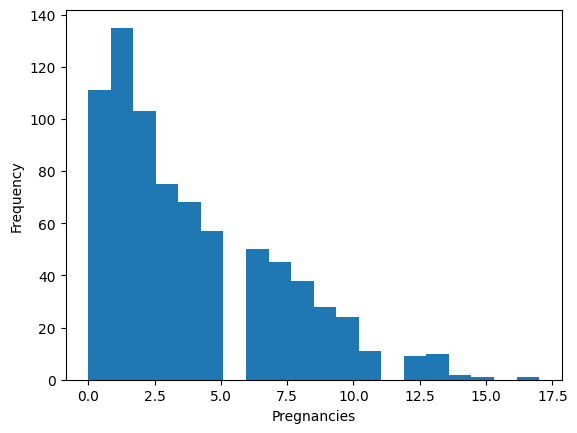

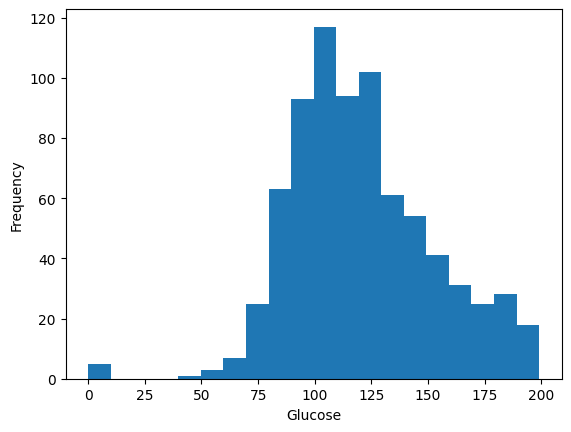

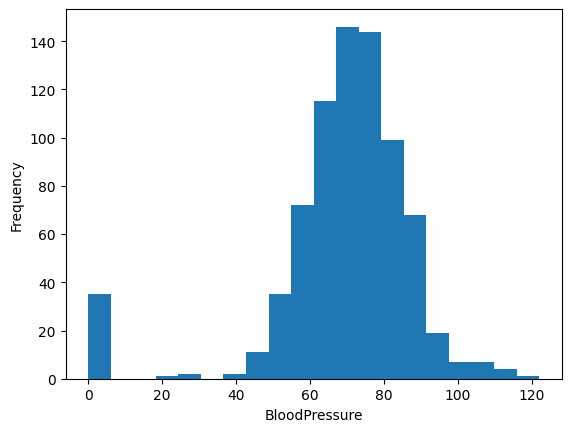

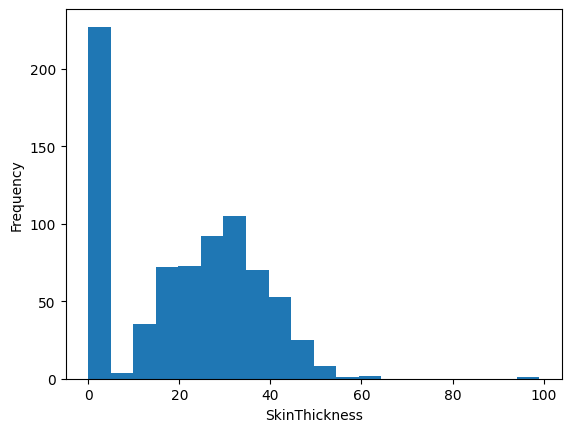

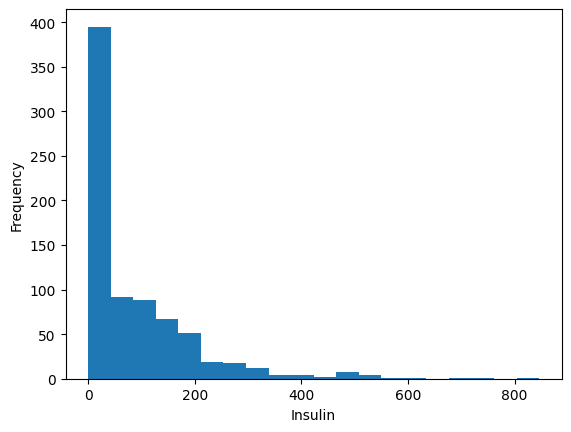

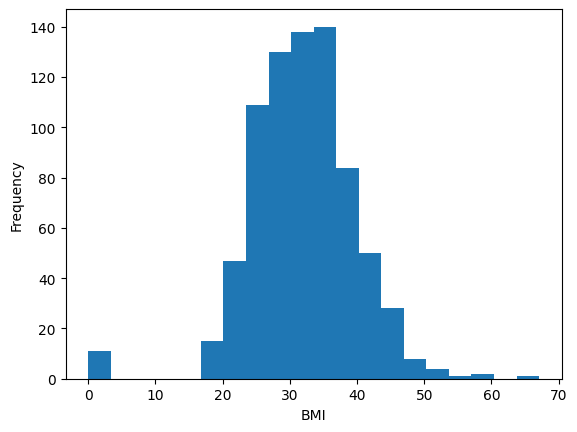

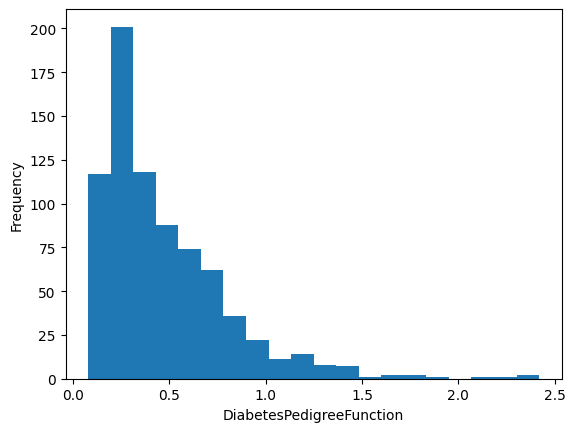

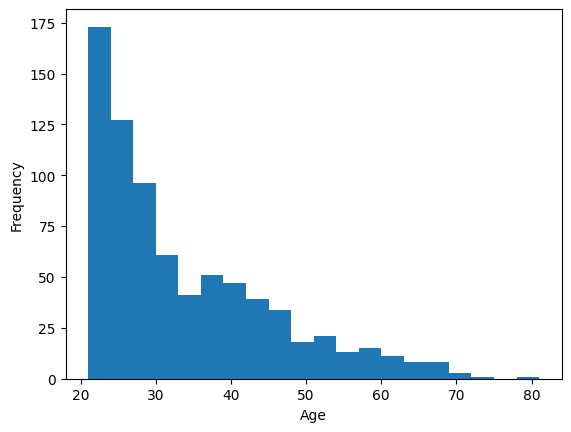

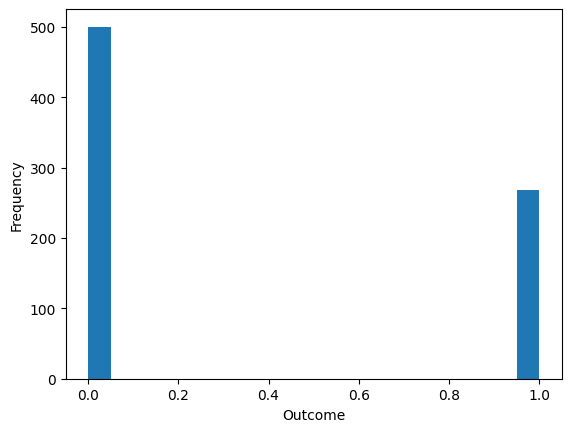

In [36]:
for col in cols:
    plt.hist(df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## Outliers handling

Based on above histogram visualization, seems like there're some outliers. However, to be precise lets check the boxplot visualization

<function matplotlib.pyplot.show(close=None, block=None)>

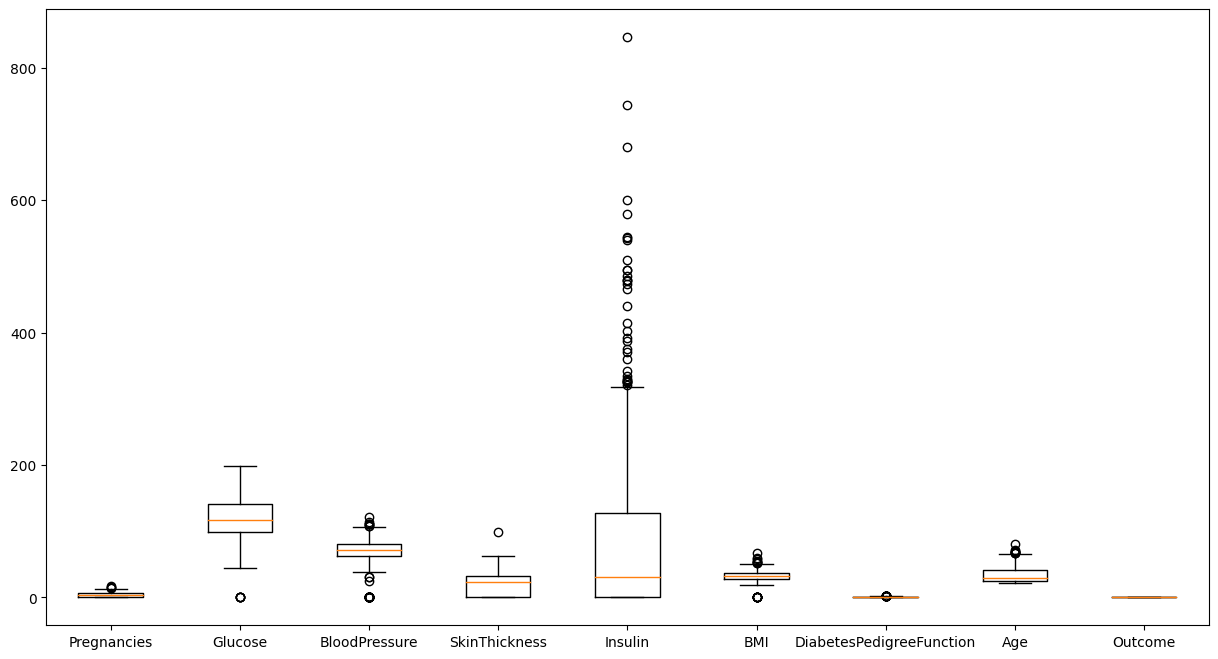

In [37]:
plt.figure(figsize=(15,8))
plt.boxplot(df.values)
plt.xticks(range(1, len(df.columns) + 1), df.columns)
plt.show

Based on boxplot visualization above, there're a lot of outliers. Therefore we need to handle these outliers carefully by logging the outliers, but before we do that let's get the outliers value

In [38]:
threshold = 2
multiplier = 1.5

dfOutliers = df.copy(deep=True)
# colsOut = df.drop(['Age', 'Outcome'], axis=1).columns.to_list()

for col in dfOutliers.drop(['Age', 'Outcome'], axis=1).columns.to_list():
    # mean = df[col].mean()
    # std = df[col].std()
    # outliers = df[col][(df[col] - mean).abs() > threshold * std]
    # dfOutliers.loc[outliers.index, col] = np.log(outliers)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # outliers = df[col][(df[col] < Q1 - multiplier * IQR) | (df[col] > Q3 + multiplier * IQR)]
    # outliers = df[column][(df[column] < Q1 - multiplier * IQR) | (df[column] > Q3 + multiplier * IQR)]
    outliers = df[col][(df[col] < Q1 - multiplier * IQR) | (df[col] > Q3 + multiplier * IQR)]
    if outliers.dtype == 'int64':
        dfOutliers.loc[outliers.index, col] = round(np.log(outliers + 1e-10))
    else:
        dfOutliers.loc[outliers.index, col] = np.log(outliers + 1e-10)

dfOutliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627000,50,1
1,1,85,66,29,0,26.6,0.351000,31,0
2,8,183,64,0,0,23.3,0.672000,32,1
3,1,89,66,23,94,28.1,0.167000,21,0
4,0,137,40,35,168,43.1,0.827678,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171000,63,0
764,2,122,70,27,0,36.8,0.340000,27,0
765,5,121,72,23,112,26.2,0.245000,30,0
766,1,126,60,0,0,30.1,0.349000,47,1


## EDA

In [39]:
dfOutliers.groupby('Outcome').count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268


Based on table above, seems like we're having an imbalance dataset

In [40]:
dfOutliers.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.842000,66.564000,19.664000,55.754000,29.686545,0.402329,31.190000
1,4.686567,141.085821,67.776119,21.813433,67.458955,33.792707,0.479117,37.067164


Based on the table above, seems like the the predicted diabetic has higher mean in almost all columns

<AxesSubplot: >

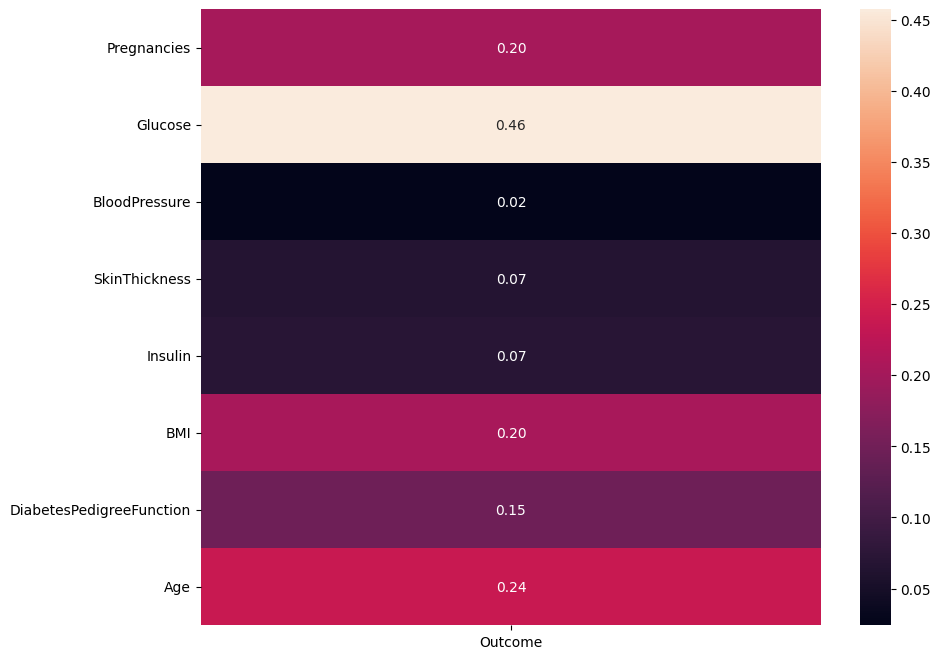

In [41]:
target = 'Outcome'
corr = dfOutliers.corr()[target]
corr = corr.drop(target)
dfCorr = pd.DataFrame(corr)
plt.figure(figsize=(10,8))
sns.heatmap(dfCorr, annot=True, fmt='.2f')

In [42]:
highCorr = dfCorr[abs(dfCorr) >= 0.2].dropna().index

In [43]:
print(highCorr)

Index(['Pregnancies', 'Glucose', 'BMI', 'Age'], dtype='object')


In [44]:
allCols = dfOutliers.copy(deep=True)
highCols = pd.concat([dfOutliers[highCorr], dfOutliers['Outcome']], axis=1)

In [45]:
scaler = MinMaxScaler()
allColsVal = scaler.fit_transform(allCols)
allColsDf = pd.DataFrame(allColsVal, columns=allCols.columns.to_list())
allColsDf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.461538,0.770270,0.736434,0.555556,0.000000,0.775422,0.493261,0.483333,1.0
1,0.076923,0.486486,0.689922,0.460317,0.000000,0.679566,0.245283,0.166667,0.0
2,0.615385,0.927928,0.674419,0.000000,0.000000,0.634376,0.533693,0.183333,1.0
3,0.076923,0.504505,0.689922,0.365079,0.295597,0.700106,0.079964,0.000000,0.0
4,0.000000,0.720721,0.488372,0.555556,0.528302,0.905513,0.673565,0.200000,1.0
...,...,...,...,...,...,...,...,...,...
763,0.769231,0.558559,0.767442,0.761905,0.566038,0.765836,0.083558,0.700000,0.0
764,0.153846,0.653153,0.720930,0.428571,0.000000,0.819242,0.235400,0.100000,0.0
765,0.384615,0.648649,0.736434,0.365079,0.352201,0.674088,0.150045,0.150000,0.0
766,0.076923,0.671171,0.643411,0.000000,0.000000,0.727494,0.243486,0.433333,1.0


In [46]:
scaler2 = MinMaxScaler()
highColsVal = scaler2.fit_transform(highCols)
highColsDf = pd.DataFrame(highColsVal, columns=highCols.columns.to_list())
highColsDf

,Pregnancies,Glucose,BMI,Age,Outcome
0,0.461538,0.770270,0.775422,0.483333,1.0
1,0.076923,0.486486,0.679566,0.166667,0.0
2,0.615385,0.927928,0.634376,0.183333,1.0
3,0.076923,0.504505,0.700106,0.000000,0.0
4,0.000000,0.720721,0.905513,0.200000,1.0
...,...,...,...,...,...
763,0.769231,0.558559,0.765836,0.700000,0.0
764,0.153846,0.653153,0.819242,0.100000,0.0
765,0.384615,0.648649,0.674088,0.150000,0.0
766,0.076923,0.671171,0.727494,0.433333,1.0


## Modelling

Since we're using pytorch to develop the deep learning model, lets create the custom dataset first then the dataloader

In [64]:
# yHighCols = torch.tensor(highColsDf[target].values, dtype=torch.float32)
# yAllCols = torch.tensor(allColsDf[target].values, dtype=torch.float32)
# bc = np.bincount(yHighCols)
# bcAll = np.bincount(yAllCols)
# cwHigh = torch.tensor([768 / (2 * bc[0]), 768 / (2 * bc[1])])
# cwAll = torch.tensor([768 / (2 * bcAll[0]), 768 / (2 * bcAll[1])])
# print(cwHigh)
# print(cwAll)

# import pandas as pd
# import torch

# Assuming your DataFrame is named df and the column of interest is 'column_name'
# column_values = highColsDf[target].values.astype(int)
# class_counts = torch.bincount(torch.from_numpy(column_values))
# total_samples = len(column_values)
# class_weights = total_samples / (len(class_counts) * class_counts.float())

# print(class_weights)

def getClassWeight(data):
    numClasses = 2
    count0 = 0
    count1 = 0
    for _, targets in data:
        count0 += torch.sum(targets[:] == 0)
        count1 += torch.sum(targets[:] == 1)
        
    weight0 = 1 / count0
    weight1 = 1 / count1
    maxWeight = max(weight0, weight1)
    weight0Norm = weight0 / maxWeight
    weight1Norm = weight1 / maxWeight
    return torch.tensor([weight0Norm, weight1Norm])


In [48]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [49]:
classNames = ['Non-diabetic', 'Diabetic']
lr = 0.01
epochs = 250

In [50]:
class customDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset.drop(target, axis=1).values
        self.target = dataset[target].values
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        inputs = torch.tensor(self.data[index], dtype=torch.float32)
        targets = torch.tensor(self.target[index], dtype=torch.float32)
        return inputs, targets

dataNormal = customDataset(allColsDf)
dataHigh = customDataset(highColsDf)

In [51]:
trainRatio = .8
valRatio = .2
batchSize = 32

trainSizeNormal = int(len(dataNormal) * trainRatio)
valSizeNormal = len(dataNormal) - trainSizeNormal

trainSizeHigh = int(len(dataHigh) * trainRatio)
valSizeHigh = len(dataHigh) - trainSizeHigh

trainSetNormal, valSetNormal = random_split(dataNormal, [trainSizeNormal, valSizeNormal])
trainSetHigh, valSetHigh = random_split(dataHigh, [trainSizeHigh, valSizeHigh])

inFeatureNormal = allCols.drop(target, axis=1).shape[1]
inFeatureHigh = highCols.drop(target, axis=1).shape[1]

sizeNormal = {
    'train' : len(trainSetNormal),
    'val' : len(valSetNormal)
}

sizeHigh = {
    'train' : len(trainSetHigh),
    'val' : len(valSetHigh)
}

# BECAREFUL WHEN DEFINING THE NUM_WORKERS AND PIN_MEMORY PARAMETER IN DATALOADER, BECAUSE IT WILL RUIN THE PERFORMANCES OF YOUR GPU AND CPU IF YOU DONT HAVE HIGH SPECS
loaderNormal = {
    'train' : DataLoader(trainSetNormal, batch_size=batchSize, shuffle=True, num_workers=8, pin_memory=True),
    'val' : DataLoader(valSetNormal, batch_size=batchSize, shuffle=False, num_workers=8, pin_memory=True)
}
loaderHigh = {
    'train' : DataLoader(trainSetHigh, batch_size=batchSize, shuffle=True, num_workers=8, pin_memory=True),
    'val' : DataLoader(valSetHigh, batch_size=batchSize, shuffle=False, num_workers=8, pin_memory=True)
}

In [81]:
cwNormal = getClassWeight(loaderNormal['train'])
cwHigh = getClassWeight(loaderHigh['train'])
cwNormalDevice = cwNormal.to(device)
cwHighDevice = cwHigh.to(device)

In [66]:
# cwNormal = np.array(cwHigh)
print(cwNormal.shape)
print(cwNormal)

torch.Size([2])
tensor([0.5274, 1.0000])


In [88]:
def trainingFunction(model, epochs, loader, size, criterion, optimizer, cw, patience=5, device=device):
    trainAccLog = []
    trainLossLog = []
    validationAccLog = []
    validationLossLog = []
    epochLog = []
    model.to(device)
    # criterion.to(device)
    earlyStop = 0
    bestLoss = float('inf')

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*10)
        epochLog.append(epoch)
        for phase in ['train', 'val']:
            if phase=='train':
                model.train()
            else:
                model.eval()
            runningLoss = .0
            runningAcc = .0
            for features, targets in tqdm(loader[phase], desc='Batch', leave=False):
                feature = features.to(device)
                target = targets.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(feature)
                    _, pred = torch.max(outputs, 1)
                    # print(outputs.squeeze().shape)
                    # print(target.shape)
                    # print(outputs.shape)
                    # weightedOutputs = outputs.to(device) * cw.to(device)  #### WEIGHTED LOGITS
                    # print(weightedOutputs)
                    # print(weightedOutputs.shape)
                    # print(target)
                    # print(target.shape)
                    # print(outputs.device)
                    # print(target.device)
                    loss = criterion(outputs, target)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                runningLoss += loss.item() * features.size(0)
                runningAcc += torch.sum(pred == target).item()
                del feature, target, outputs, _, pred
                torch.cuda.empty_cache()
            epochLoss = runningLoss / size[phase]
            epochAcc = runningAcc / size[phase]
            if phase == 'train':
                trainAccLog.append(epochAcc)
                trainLossLog.append(epochLoss)
            elif phase == 'val':
                validationAccLog.append(epochAcc)
                validationLossLog.append(epochLoss)
                if patience:
                    if epochLoss < bestLoss:
                        bestLoss = epochLoss
                        earlyStop = 0
                    else:
                        earlyStop += 1
            tqdm.write(f'{phase} phase Accuracy : {epochAcc:.4f} and Loss : {epochLoss:.4f}')

        if earlyStop >= patience:
            tqdm.write(f'Early stopping, no improvement in {patience} epochs')
            break
        print()
    tqdm.write('Training Finished')
    return (model, epochLog, trainAccLog, trainLossLog, validationAccLog, validationLossLog)

In [94]:
def visLog(epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle):
    fig, ax = plt.subplots(nrows=2, figsize=(10,8))
    # trainAcc = [x.cpu() for x in trainAcc]
    # validationAcc = [x.cpu() for x in validationAcc]
    
    ax[0].plot(epochLog, trainLoss, label='Training Loss')
    ax[0].plot(epochLog, validationLoss, label='Validation Loss')
    ax[0].set(xlabel="Epoch", ylabel="Loss", title="Train & Validation Loss")
    
    ax[1].plot(epochLog, trainAcc, label='Training Accuracy')
    ax[1].plot(epochLog, validationAcc, label='Validation Accuracy')
    ax[1].set(xlabel="Epoch", ylabel="Accuracy", title="Train & Validation Accuracy")

    ax[0].legend()
    ax[1].legend()
    plt.suptitle(supTitle)
    fig.tight_layout(pad=2.0)
    plt.show()

In [97]:
def evalFunction(model, loader, epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle, device=device):
    plt.figure(figsize=(10,8))
    total = 0
    correct = 0
    pred = []
    truth = []

    with torch.no_grad():
        model.eval()
        for i, (features, targets) in enumerate(loader['val']):
            feature = features.to(device)
            target = targets.to(device)

            outputs = model(feature)
            _, preds = torch.max(outputs, 1)

            pred.extend(preds.data.cpu().numpy())
            truth.extend(target.data.cpu().numpy())

            total+=target.size(0)
            correct+=(preds==target).sum().item()
        
        visLog(epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle)

        print(classification_report(truth, pred, target_names=classNames))
        print(f'accuracy on the model was {100 * correct / total}%')
        cfMatrix = confusion_matrix(truth, pred)
        df = pd.DataFrame(cfMatrix, index=[i for i in classNames], columns=[i for i in classNames])
        sns.heatmap(df, annot=True, fmt='.0f')


### Model for all columns

List of model:
- model1 : deep and wide
- model2 : deep and shallow
- model3 : narrow and wide
- model4 : narrow and shallow

In [68]:
class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=256, out_features=128)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=128, out_features=64)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=64, out_features=32)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=32, out_features=2)
    def forward(self,x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model1 = model1()
summary(model1, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model1                                   [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 512]               4,608
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 128]               32,896
├─ReLU: 1-6                              [1, 1, 128]               --
├─Linear: 1-7                            [1, 1, 64]                8,256
├─ReLU: 1-8                              [1, 1, 64]                --
├─Linear: 1-9                            [1, 1, 32]                2,080
├─ReLU: 1-10                             [1, 1, 32]                --
├─Linear: 1-11                           [1, 1, 2]                 66
Total params: 179,234
Trainable params: 179,234
Non-trainable param

In [104]:
class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=128)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=128, out_features=64)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=64, out_features=32)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=32, out_features=16)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=16, out_features=8)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model2 = model2()
summary(model2, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model2                                   [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 128]               1,152
├─ReLU: 1-2                              [1, 1, 128]               --
├─Linear: 1-3                            [1, 1, 64]                8,256
├─ReLU: 1-4                              [1, 1, 64]                --
├─Linear: 1-5                            [1, 1, 32]                2,080
├─ReLU: 1-6                              [1, 1, 32]                --
├─Linear: 1-7                            [1, 1, 16]                528
├─ReLU: 1-8                              [1, 1, 16]                --
├─Linear: 1-9                            [1, 1, 8]                 136
├─ReLU: 1-10                             [1, 1, 8]                 --
├─Linear: 1-11                           [1, 1, 2]                 18
Total params: 12,170
Trainable params: 12,170
Non-trainable params: 0
Tota

In [105]:
class model3(nn.Module):
    def __init__(self):
        super(model3, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=256, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model3 = model3()
summary(model3, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model3                                   [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 512]               4,608
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 2]                 514
Total params: 136,450
Trainable params: 136,450
Non-trainable params: 0
Total mult-adds (M): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.55
Estimated Total Size (MB): 0.55

In [106]:
class model4(nn.Module):
    def __init__(self):
        super(model4, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=16)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=16, out_features=8)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model4 = model4()
summary(model4, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model4                                   [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 16]                144
├─ReLU: 1-2                              [1, 1, 16]                --
├─Linear: 1-3                            [1, 1, 8]                 136
├─ReLU: 1-4                              [1, 1, 8]                 --
├─Linear: 1-5                            [1, 1, 2]                 18
Total params: 298
Trainable params: 298
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Model for high corr cols

List of the model still the same with the model above

In [107]:
class model1high(nn.Module):
    def __init__(self):
        super(model1high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=256, out_features=128)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=128, out_features=64)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=64, out_features=32)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=32, out_features=2)
    def forward(self,x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model1high = model1high()
summary(model1high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model1high                               [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 512]               2,560
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 128]               32,896
├─ReLU: 1-6                              [1, 1, 128]               --
├─Linear: 1-7                            [1, 1, 64]                8,256
├─ReLU: 1-8                              [1, 1, 64]                --
├─Linear: 1-9                            [1, 1, 32]                2,080
├─ReLU: 1-10                             [1, 1, 32]                --
├─Linear: 1-11                           [1, 1, 2]                 66
Total params: 177,186
Trainable params: 177,186
Non-trainable param

In [108]:
class model2high(nn.Module):
    def __init__(self):
        super(model2high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=128)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=128, out_features=64)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=64, out_features=32)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=32, out_features=16)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=16, out_features=8)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model2high = model2high()
summary(model2high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model2high                               [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 128]               640
├─ReLU: 1-2                              [1, 1, 128]               --
├─Linear: 1-3                            [1, 1, 64]                8,256
├─ReLU: 1-4                              [1, 1, 64]                --
├─Linear: 1-5                            [1, 1, 32]                2,080
├─ReLU: 1-6                              [1, 1, 32]                --
├─Linear: 1-7                            [1, 1, 16]                528
├─ReLU: 1-8                              [1, 1, 16]                --
├─Linear: 1-9                            [1, 1, 8]                 136
├─ReLU: 1-10                             [1, 1, 8]                 --
├─Linear: 1-11                           [1, 1, 2]                 18
Total params: 11,658
Trainable params: 11,658
Non-trainable params: 0
Total 

In [109]:
class model3high(nn.Module):
    def __init__(self):
        super(model3high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=256, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model3high = model3high()
summary(model3high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model3high                               [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 512]               2,560
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 2]                 514
Total params: 134,402
Trainable params: 134,402
Non-trainable params: 0
Total mult-adds (M): 0.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.54
Estimated Total Size (MB): 0.54

In [110]:
class model4high(nn.Module):
    def __init__(self):
        super(model4high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=16)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=16, out_features=8)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model4high = model4high()
summary(model4high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model4high                               [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 16]                80
├─ReLU: 1-2                              [1, 1, 16]                --
├─Linear: 1-3                            [1, 1, 8]                 136
├─ReLU: 1-4                              [1, 1, 8]                 --
├─Linear: 1-5                            [1, 1, 2]                 18
Total params: 234
Trainable params: 234
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Training all cols

We're using Adam optimizer with the learning rate of 0.01 and no regularization to get to know about the regularization effect in deep learning

In [89]:
#model1
criterion1 = nn.CrossEntropyLoss(weight=cwNormalDevice)
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
trainedModel1, epochLog1, trainAccLog1, trainLossLog1, validationAccLog1, validationLossLog1 = trainingFunction(model1, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion1, optimizer=optimizer1, cw=cwNormalDevice)

Epoch 1/250
----------


train phase Accuracy : 0.3681 and Loss : 0.6971


val phase Accuracy : 0.6364 and Loss : 0.6929

Epoch 2/250
----------


train phase Accuracy : 0.6938 and Loss : 0.6473


val phase Accuracy : 0.7143 and Loss : 0.6418

Epoch 3/250
----------


train phase Accuracy : 0.6547 and Loss : 0.6115


val phase Accuracy : 0.6818 and Loss : 0.5802

Epoch 4/250
----------


train phase Accuracy : 0.7068 and Loss : 0.5823


val phase Accuracy : 0.6688 and Loss : 0.5802

Epoch 5/250
----------


train phase Accuracy : 0.7036 and Loss : 0.5612


val phase Accuracy : 0.7338 and Loss : 0.5824

Epoch 6/250
----------


train phase Accuracy : 0.7476 and Loss : 0.5586


val phase Accuracy : 0.7208 and Loss : 0.6028

Epoch 7/250
----------


train phase Accuracy : 0.7736 and Loss : 0.5421


val phase Accuracy : 0.6234 and Loss : 0.6359

Epoch 8/250
----------


train phase Accuracy : 0.6221 and Loss : 0.6675


val phase Accuracy : 0.7208 and Loss : 0.6673

Epoch 9/250
----------


train phase Accuracy : 0.6596 and Loss : 0.6304


val phase Accuracy : 0.7013 and Loss : 0.6748
Early stopping, no improvement in 5 epochs
Training Finished


In [111]:
#model2
criterion2 = nn.CrossEntropyLoss(weight=cwNormalDevice)
optimizer2 = optim.Adam(model2.parameters(), lr=lr)
trainedModel2, epochLog2, trainAccLog2, trainLossLog2, validationAccLog2, validationLossLog2 = trainingFunction(model2, epochs=epochs, cw=cwNormal, loader=loaderNormal, size=sizeNormal, criterion=criterion2, optimizer=optimizer2)

Epoch 1/250
----------


train phase Accuracy : 0.5586 and Loss : 0.6932


val phase Accuracy : 0.6753 and Loss : 0.6823

Epoch 2/250
----------


train phase Accuracy : 0.6564 and Loss : 0.6954


val phase Accuracy : 0.6364 and Loss : 0.6978

Epoch 3/250
----------


train phase Accuracy : 0.6433 and Loss : 0.6694


val phase Accuracy : 0.7013 and Loss : 0.6374

Epoch 4/250
----------


train phase Accuracy : 0.6824 and Loss : 0.6062


val phase Accuracy : 0.6494 and Loss : 0.7404

Epoch 5/250
----------


train phase Accuracy : 0.6580 and Loss : 0.6294


val phase Accuracy : 0.7078 and Loss : 0.5920

Epoch 6/250
----------


train phase Accuracy : 0.6661 and Loss : 0.6108


val phase Accuracy : 0.7013 and Loss : 0.6340

Epoch 7/250
----------


train phase Accuracy : 0.7362 and Loss : 0.5575


val phase Accuracy : 0.7013 and Loss : 0.6044

Epoch 8/250
----------


train phase Accuracy : 0.7101 and Loss : 0.5807


val phase Accuracy : 0.6299 and Loss : 0.6226

Epoch 9/250
----------


train phase Accuracy : 0.7085 and Loss : 0.5650


val phase Accuracy : 0.7143 and Loss : 0.5964

Epoch 10/250
----------


train phase Accuracy : 0.7166 and Loss : 0.5845


val phase Accuracy : 0.6104 and Loss : 0.6068
Early stopping, no improvement in 5 epochs
Training Finished


In [113]:
#model3
criterion3 = nn.CrossEntropyLoss(weight=cwNormalDevice)
optimizer3 = optim.Adam(model3.parameters(), lr=lr)
trainedModel3, epochLog3, trainAccLog3, trainLossLog3, validationAccLog3, validationLossLog3 = trainingFunction(model3, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion3, optimizer=optimizer3, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.6124 and Loss : 0.6722


val phase Accuracy : 0.4675 and Loss : 0.6688

Epoch 2/250
----------


train phase Accuracy : 0.6612 and Loss : 0.5959


val phase Accuracy : 0.6688 and Loss : 0.5915

Epoch 3/250
----------


train phase Accuracy : 0.7101 and Loss : 0.5792


val phase Accuracy : 0.7143 and Loss : 0.6117

Epoch 4/250
----------


train phase Accuracy : 0.7101 and Loss : 0.5658


val phase Accuracy : 0.7338 and Loss : 0.5805

Epoch 5/250
----------


train phase Accuracy : 0.7280 and Loss : 0.5552


val phase Accuracy : 0.7013 and Loss : 0.5822

Epoch 6/250
----------


train phase Accuracy : 0.7410 and Loss : 0.5446


val phase Accuracy : 0.7338 and Loss : 0.6198

Epoch 7/250
----------


train phase Accuracy : 0.7199 and Loss : 0.5581


val phase Accuracy : 0.6494 and Loss : 0.5856

Epoch 8/250
----------


train phase Accuracy : 0.7329 and Loss : 0.5517


val phase Accuracy : 0.7273 and Loss : 0.5828

Epoch 9/250
----------


train phase Accuracy : 0.7068 and Loss : 0.6036


val phase Accuracy : 0.6818 and Loss : 0.6401
Early stopping, no improvement in 5 epochs
Training Finished


In [115]:
#model4
criterion4 = nn.CrossEntropyLoss(weight=cwNormalDevice)
optimizer4 = optim.Adam(model4.parameters(), lr=lr)
trainedModel4, epochLog4, trainAccLog4, trainLossLog4, validationAccLog4, validationLossLog4 = trainingFunction(model4, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion4, optimizer=optimizer4, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.4788 and Loss : 0.6875


val phase Accuracy : 0.6494 and Loss : 0.6756

Epoch 2/250
----------


train phase Accuracy : 0.6287 and Loss : 0.6686


val phase Accuracy : 0.6169 and Loss : 0.6472

Epoch 3/250
----------


train phase Accuracy : 0.6743 and Loss : 0.6390


val phase Accuracy : 0.6688 and Loss : 0.6316

Epoch 4/250
----------


train phase Accuracy : 0.6824 and Loss : 0.6111


val phase Accuracy : 0.6688 and Loss : 0.6132

Epoch 5/250
----------


train phase Accuracy : 0.7036 and Loss : 0.5902


val phase Accuracy : 0.7078 and Loss : 0.6012

Epoch 6/250
----------


train phase Accuracy : 0.7345 and Loss : 0.5727


val phase Accuracy : 0.7143 and Loss : 0.6030

Epoch 7/250
----------


train phase Accuracy : 0.7296 and Loss : 0.5630


val phase Accuracy : 0.6948 and Loss : 0.6561

Epoch 8/250
----------


train phase Accuracy : 0.7182 and Loss : 0.5696


val phase Accuracy : 0.6623 and Loss : 0.5994

Epoch 9/250
----------


train phase Accuracy : 0.7150 and Loss : 0.5614


val phase Accuracy : 0.6688 and Loss : 0.5912

Epoch 10/250
----------


train phase Accuracy : 0.7117 and Loss : 0.5756


val phase Accuracy : 0.7273 and Loss : 0.5975

Epoch 11/250
----------


train phase Accuracy : 0.7296 and Loss : 0.5555


val phase Accuracy : 0.7403 and Loss : 0.5792

Epoch 12/250
----------


train phase Accuracy : 0.7362 and Loss : 0.5563


val phase Accuracy : 0.5390 and Loss : 0.6411

Epoch 13/250
----------


train phase Accuracy : 0.7182 and Loss : 0.5627


val phase Accuracy : 0.7403 and Loss : 0.6002

Epoch 14/250
----------


train phase Accuracy : 0.7264 and Loss : 0.5652


val phase Accuracy : 0.7338 and Loss : 0.6114

Epoch 15/250
----------


train phase Accuracy : 0.7248 and Loss : 0.5565


val phase Accuracy : 0.7208 and Loss : 0.5775

Epoch 16/250
----------


train phase Accuracy : 0.7459 and Loss : 0.5575


val phase Accuracy : 0.7403 and Loss : 0.5909

Epoch 17/250
----------


train phase Accuracy : 0.7410 and Loss : 0.5459


val phase Accuracy : 0.7532 and Loss : 0.5884

Epoch 18/250
----------


train phase Accuracy : 0.7492 and Loss : 0.5440


val phase Accuracy : 0.7013 and Loss : 0.5773

Epoch 19/250
----------


train phase Accuracy : 0.7443 and Loss : 0.5455


val phase Accuracy : 0.7403 and Loss : 0.6312

Epoch 20/250
----------


train phase Accuracy : 0.7280 and Loss : 0.5574


val phase Accuracy : 0.7338 and Loss : 0.5890

Epoch 21/250
----------


train phase Accuracy : 0.7215 and Loss : 0.5561


val phase Accuracy : 0.7597 and Loss : 0.5927

Epoch 22/250
----------


train phase Accuracy : 0.7329 and Loss : 0.5475


val phase Accuracy : 0.7208 and Loss : 0.5871

Epoch 23/250
----------


train phase Accuracy : 0.7492 and Loss : 0.5495


val phase Accuracy : 0.7468 and Loss : 0.5859
Early stopping, no improvement in 5 epochs
Training Finished


## Training high corr cols

In [116]:
#model1
criterion1high = nn.CrossEntropyLoss(weight=cwHighDevice)
optimizer1high = optim.Adam(model1high.parameters(), lr=lr)
highTrainedModel1, highEpochLog1, highTrainAccLog1, highTrainLossLog1, highValidationAccLog1, highValidationLossLog1 = trainingFunction(model1high, epochs, loaderHigh, sizeHigh, criterion1high, optimizer1high, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.5749 and Loss : 0.6998


val phase Accuracy : 0.6948 and Loss : 0.6493

Epoch 2/250
----------


train phase Accuracy : 0.6954 and Loss : 0.6037


val phase Accuracy : 0.7597 and Loss : 0.5947

Epoch 3/250
----------


train phase Accuracy : 0.6938 and Loss : 0.6043


val phase Accuracy : 0.7403 and Loss : 0.5934

Epoch 4/250
----------


train phase Accuracy : 0.6906 and Loss : 0.5832


val phase Accuracy : 0.7468 and Loss : 0.6193

Epoch 5/250
----------


train phase Accuracy : 0.6906 and Loss : 0.5832


val phase Accuracy : 0.7403 and Loss : 0.5572

Epoch 6/250
----------


train phase Accuracy : 0.7199 and Loss : 0.5733


val phase Accuracy : 0.7987 and Loss : 0.5325

Epoch 7/250
----------


train phase Accuracy : 0.6938 and Loss : 0.5864


val phase Accuracy : 0.7403 and Loss : 0.6257

Epoch 8/250
----------


train phase Accuracy : 0.7117 and Loss : 0.5884


val phase Accuracy : 0.7922 and Loss : 0.5464

Epoch 9/250
----------


train phase Accuracy : 0.7264 and Loss : 0.5632


val phase Accuracy : 0.8182 and Loss : 0.5309

Epoch 10/250
----------


train phase Accuracy : 0.7443 and Loss : 0.5583


val phase Accuracy : 0.7532 and Loss : 0.5384

Epoch 11/250
----------


train phase Accuracy : 0.7117 and Loss : 0.5655


val phase Accuracy : 0.7597 and Loss : 0.5399

Epoch 12/250
----------


train phase Accuracy : 0.7085 and Loss : 0.5857


val phase Accuracy : 0.7468 and Loss : 0.5662

Epoch 13/250
----------


train phase Accuracy : 0.7410 and Loss : 0.5550


val phase Accuracy : 0.7857 and Loss : 0.5422

Epoch 14/250
----------


train phase Accuracy : 0.7557 and Loss : 0.5467


val phase Accuracy : 0.7468 and Loss : 0.5910
Early stopping, no improvement in 5 epochs
Training Finished


In [117]:
#model2
criterion2high = nn.CrossEntropyLoss(weight=cwHighDevice)
optimizer2high = optim.Adam(model2high.parameters(), lr=lr)
highTrainedModel2, highEpochLog2, highTrainAccLog2, highTrainLossLog2, highValidationAccLog2, highValidationLossLog2 = trainingFunction(model2high, epochs, loaderHigh, sizeHigh, criterion2high, optimizer2high, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.3518 and Loss : 0.6989


val phase Accuracy : 0.3377 and Loss : 0.6949

Epoch 2/250
----------


train phase Accuracy : 0.5423 and Loss : 0.6910


val phase Accuracy : 0.6623 and Loss : 0.6878

Epoch 3/250
----------


train phase Accuracy : 0.6971 and Loss : 0.6531


val phase Accuracy : 0.6688 and Loss : 0.7116

Epoch 4/250
----------


train phase Accuracy : 0.6498 and Loss : 0.6373


val phase Accuracy : 0.7403 and Loss : 0.5408

Epoch 5/250
----------


train phase Accuracy : 0.7215 and Loss : 0.5894


val phase Accuracy : 0.7338 and Loss : 0.5455

Epoch 6/250
----------


train phase Accuracy : 0.7345 and Loss : 0.5700


val phase Accuracy : 0.6429 and Loss : 0.6031

Epoch 7/250
----------


train phase Accuracy : 0.7215 and Loss : 0.5750


val phase Accuracy : 0.7597 and Loss : 0.6039

Epoch 8/250
----------


train phase Accuracy : 0.7362 and Loss : 0.5636


val phase Accuracy : 0.7078 and Loss : 0.7024

Epoch 9/250
----------


train phase Accuracy : 0.7085 and Loss : 0.5868


val phase Accuracy : 0.7532 and Loss : 0.6295
Early stopping, no improvement in 5 epochs
Training Finished


In [118]:
#model3
criterion3high = nn.CrossEntropyLoss(weight=cwHighDevice)
optimizer3high = optim.Adam(model3high.parameters(), lr=lr)
highTrainedModel3, highEpochLog3, highTrainAccLog3, highTrainLossLog3, highValidationAccLog3, highValidationLossLog3 = trainingFunction(model3high, epochs, loaderHigh, sizeHigh, criterion3high, optimizer3high, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.5977 and Loss : 0.6659


val phase Accuracy : 0.7013 and Loss : 0.6159

Epoch 2/250
----------


train phase Accuracy : 0.7003 and Loss : 0.6093


val phase Accuracy : 0.7273 and Loss : 0.5538

Epoch 3/250
----------


train phase Accuracy : 0.6726 and Loss : 0.5927


val phase Accuracy : 0.7727 and Loss : 0.5318

Epoch 4/250
----------


train phase Accuracy : 0.7378 and Loss : 0.5843


val phase Accuracy : 0.7403 and Loss : 0.5517

Epoch 5/250
----------


train phase Accuracy : 0.7459 and Loss : 0.5568


val phase Accuracy : 0.7013 and Loss : 0.5609

Epoch 6/250
----------


train phase Accuracy : 0.7264 and Loss : 0.5614


val phase Accuracy : 0.7468 and Loss : 0.6475

Epoch 7/250
----------


train phase Accuracy : 0.7052 and Loss : 0.5869


val phase Accuracy : 0.7922 and Loss : 0.5511

Epoch 8/250
----------


train phase Accuracy : 0.7345 and Loss : 0.5657


val phase Accuracy : 0.7338 and Loss : 0.5394
Early stopping, no improvement in 5 epochs
Training Finished


In [119]:
#model4
criterion4high = nn.CrossEntropyLoss(weight=cwHighDevice)
optimizer4high = optim.Adam(model4high.parameters(), lr=lr)
highTrainedModel4, highEpochLog4, highTrainAccLog4, highTrainLossLog4, highValidationAccLog4, highValidationLossLog4 = trainingFunction(model4high, epochs, loaderHigh, sizeHigh, criterion4high, optimizer4high, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.5212 and Loss : 0.6939


val phase Accuracy : 0.3377 and Loss : 0.6922

Epoch 2/250
----------


train phase Accuracy : 0.3876 and Loss : 0.6912


val phase Accuracy : 0.7403 and Loss : 0.6880

Epoch 3/250
----------


train phase Accuracy : 0.6710 and Loss : 0.6859


val phase Accuracy : 0.7273 and Loss : 0.6766

Epoch 4/250
----------


train phase Accuracy : 0.6808 and Loss : 0.6740


val phase Accuracy : 0.7078 and Loss : 0.6556

Epoch 5/250
----------


train phase Accuracy : 0.6710 and Loss : 0.6616


val phase Accuracy : 0.7208 and Loss : 0.6337

Epoch 6/250
----------


train phase Accuracy : 0.6792 and Loss : 0.6451


val phase Accuracy : 0.7143 and Loss : 0.6206

Epoch 7/250
----------


train phase Accuracy : 0.6954 and Loss : 0.6269


val phase Accuracy : 0.7338 and Loss : 0.6052

Epoch 8/250
----------


train phase Accuracy : 0.7003 and Loss : 0.6134


val phase Accuracy : 0.6364 and Loss : 0.6214

Epoch 9/250
----------


train phase Accuracy : 0.6547 and Loss : 0.6237


val phase Accuracy : 0.7662 and Loss : 0.5782

Epoch 10/250
----------


train phase Accuracy : 0.6971 and Loss : 0.6037


val phase Accuracy : 0.7662 and Loss : 0.5713

Epoch 11/250
----------


train phase Accuracy : 0.6987 and Loss : 0.5953


val phase Accuracy : 0.7597 and Loss : 0.5712

Epoch 12/250
----------


train phase Accuracy : 0.7264 and Loss : 0.5897


val phase Accuracy : 0.6818 and Loss : 0.5865

Epoch 13/250
----------


train phase Accuracy : 0.6987 and Loss : 0.5898


val phase Accuracy : 0.6883 and Loss : 0.5836

Epoch 14/250
----------


train phase Accuracy : 0.6482 and Loss : 0.6087


val phase Accuracy : 0.7727 and Loss : 0.5531

Epoch 15/250
----------


train phase Accuracy : 0.7052 and Loss : 0.5850


val phase Accuracy : 0.7857 and Loss : 0.5494

Epoch 16/250
----------


train phase Accuracy : 0.6971 and Loss : 0.5836


val phase Accuracy : 0.7792 and Loss : 0.5489

Epoch 17/250
----------


train phase Accuracy : 0.6808 and Loss : 0.5879


val phase Accuracy : 0.7857 and Loss : 0.5526

Epoch 18/250
----------


train phase Accuracy : 0.7036 and Loss : 0.5790


val phase Accuracy : 0.7987 and Loss : 0.5438

Epoch 19/250
----------


train phase Accuracy : 0.6954 and Loss : 0.5851


val phase Accuracy : 0.7987 and Loss : 0.5410

Epoch 20/250
----------


train phase Accuracy : 0.7068 and Loss : 0.5753


val phase Accuracy : 0.7792 and Loss : 0.5424

Epoch 21/250
----------


train phase Accuracy : 0.7150 and Loss : 0.5792


val phase Accuracy : 0.6818 and Loss : 0.5701

Epoch 22/250
----------


train phase Accuracy : 0.7003 and Loss : 0.5772


val phase Accuracy : 0.7857 and Loss : 0.5371

Epoch 23/250
----------


train phase Accuracy : 0.6987 and Loss : 0.5804


val phase Accuracy : 0.7532 and Loss : 0.5473

Epoch 24/250
----------


train phase Accuracy : 0.7003 and Loss : 0.5770


val phase Accuracy : 0.7922 and Loss : 0.5348

Epoch 25/250
----------


train phase Accuracy : 0.7134 and Loss : 0.5780


val phase Accuracy : 0.7597 and Loss : 0.5535

Epoch 26/250
----------


train phase Accuracy : 0.7003 and Loss : 0.5787


val phase Accuracy : 0.7338 and Loss : 0.5545

Epoch 27/250
----------


train phase Accuracy : 0.7150 and Loss : 0.5736


val phase Accuracy : 0.7922 and Loss : 0.5332

Epoch 28/250
----------


train phase Accuracy : 0.7182 and Loss : 0.5682


val phase Accuracy : 0.7273 and Loss : 0.5556

Epoch 29/250
----------


train phase Accuracy : 0.7020 and Loss : 0.5748


val phase Accuracy : 0.7727 and Loss : 0.5403

Epoch 30/250
----------


train phase Accuracy : 0.7117 and Loss : 0.5698


val phase Accuracy : 0.7792 and Loss : 0.5338

Epoch 31/250
----------


train phase Accuracy : 0.7085 and Loss : 0.5687


val phase Accuracy : 0.8052 and Loss : 0.5342

Epoch 32/250
----------


train phase Accuracy : 0.7020 and Loss : 0.5667


val phase Accuracy : 0.7987 and Loss : 0.5362
Early stopping, no improvement in 5 epochs
Training Finished


## Evaluation all cols

<Figure size 1000x800 with 0 Axes>

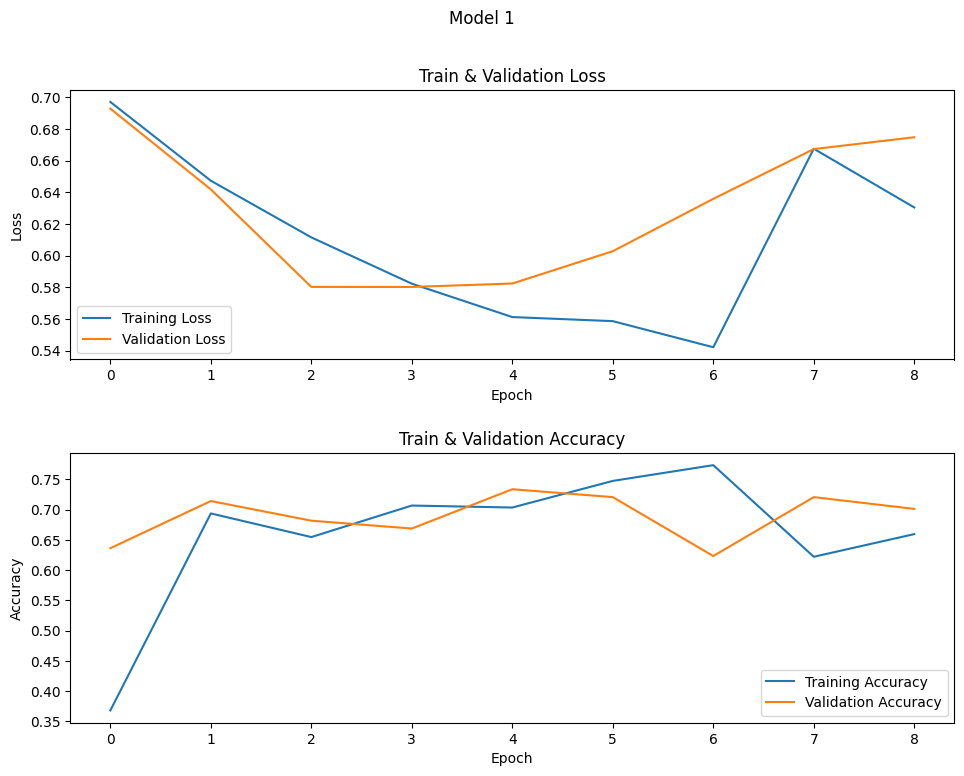

              precision    recall  f1-score   support

Non-diabetic       0.71      0.90      0.79        98
    Diabetic       0.67      0.36      0.47        56

    accuracy                           0.70       154
   macro avg       0.69      0.63      0.63       154
weighted avg       0.69      0.70      0.67       154

accuracy on the model was 70.12987012987013%


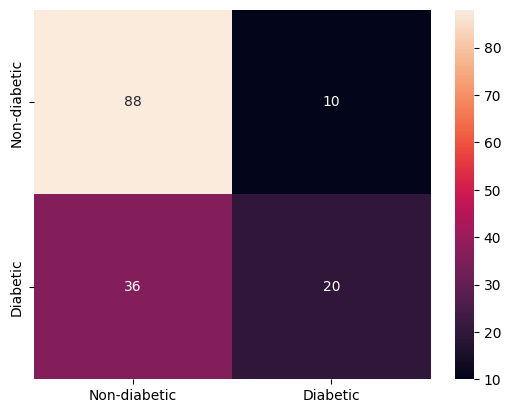

In [120]:
#model1
evalFunction(model1, loaderNormal, epochLog1, trainAccLog1, trainLossLog1, validationAccLog1, validationLossLog1, 'Model 1')

<Figure size 1000x800 with 0 Axes>

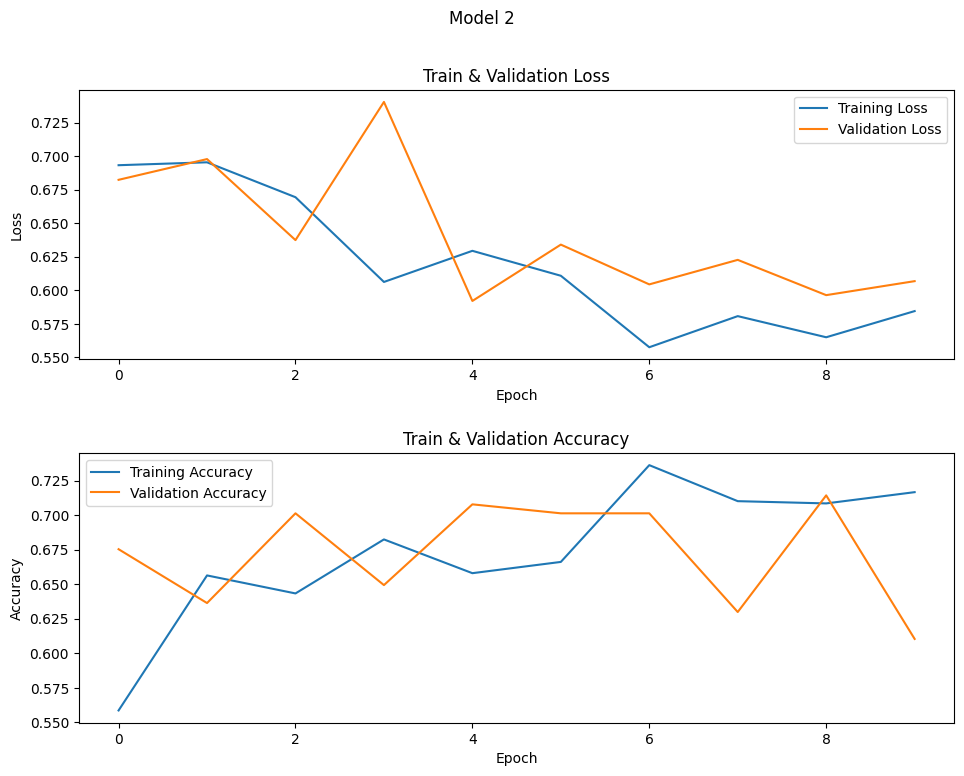

              precision    recall  f1-score   support

Non-diabetic       0.83      0.49      0.62        98
    Diabetic       0.48      0.82      0.61        56

    accuracy                           0.61       154
   macro avg       0.65      0.66      0.61       154
weighted avg       0.70      0.61      0.61       154

accuracy on the model was 61.03896103896104%


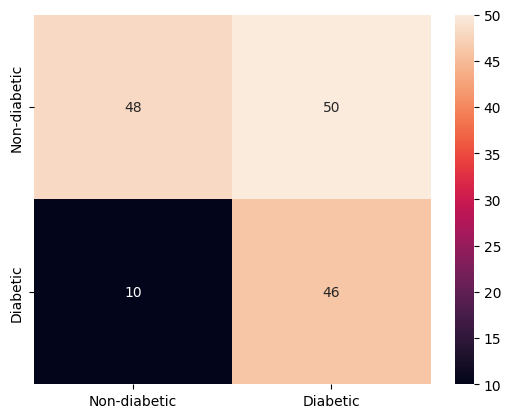

In [121]:
#model2
evalFunction(model2, loaderNormal, epochLog2, trainAccLog2, trainLossLog2, validationAccLog2, validationLossLog2, 'Model 2')

<Figure size 1000x800 with 0 Axes>

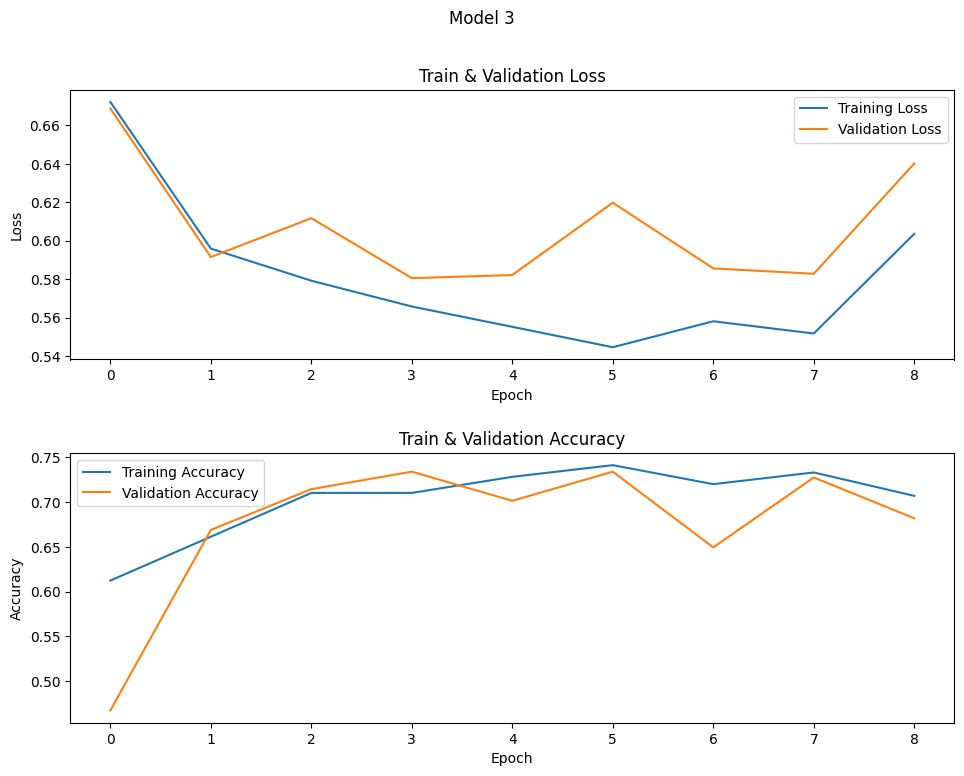

              precision    recall  f1-score   support

Non-diabetic       0.75      0.76      0.75        98
    Diabetic       0.56      0.55      0.56        56

    accuracy                           0.68       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.68      0.68      0.68       154

accuracy on the model was 68.18181818181819%


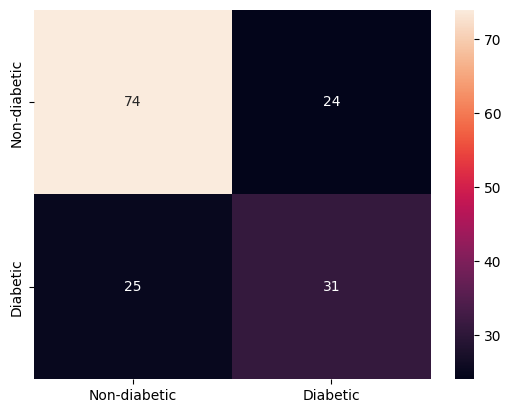

In [122]:
#model3
evalFunction(model3, loaderNormal, epochLog3, trainAccLog3, trainLossLog3, validationAccLog3, validationLossLog3, 'Model 3')

<Figure size 1000x800 with 0 Axes>

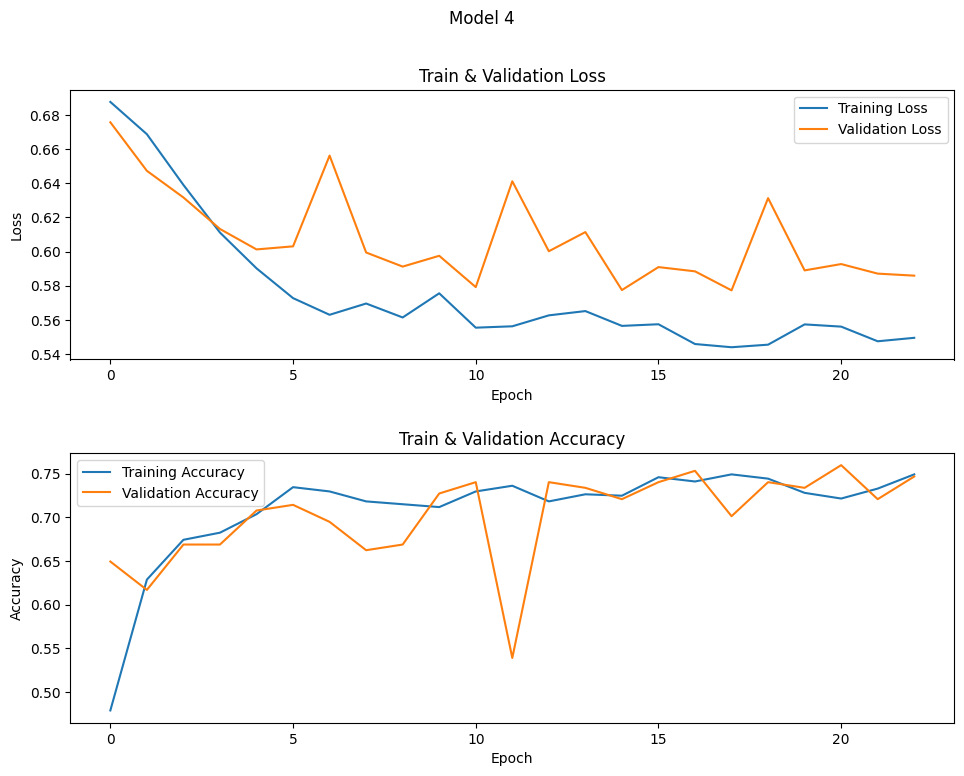

              precision    recall  f1-score   support

Non-diabetic       0.79      0.82      0.80        98
    Diabetic       0.66      0.62      0.64        56

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.74      0.75      0.75       154

accuracy on the model was 74.67532467532467%


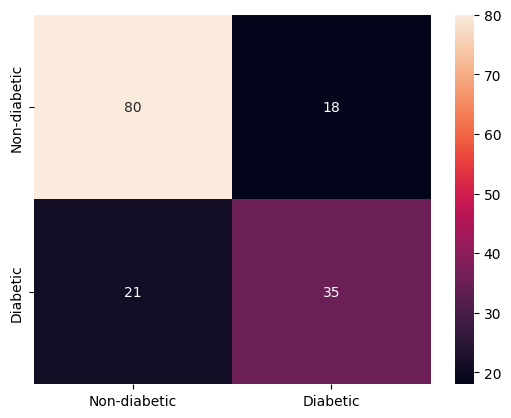

In [123]:
#model4
evalFunction(model4, loaderNormal, epochLog4, trainAccLog4, trainLossLog4, validationAccLog4, validationLossLog4, 'Model 4')

## Evaluation high corr cols

<Figure size 1000x800 with 0 Axes>

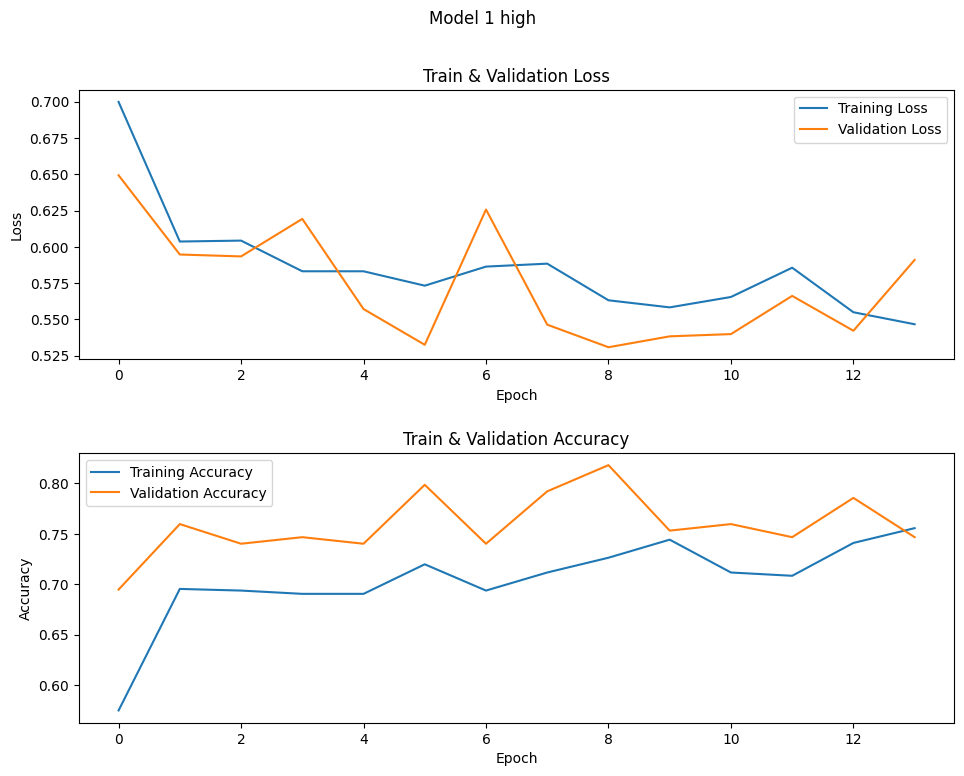

              precision    recall  f1-score   support

Non-diabetic       0.76      0.91      0.83       102
    Diabetic       0.71      0.42      0.53        52

    accuracy                           0.75       154
   macro avg       0.73      0.67      0.68       154
weighted avg       0.74      0.75      0.73       154

accuracy on the model was 74.67532467532467%


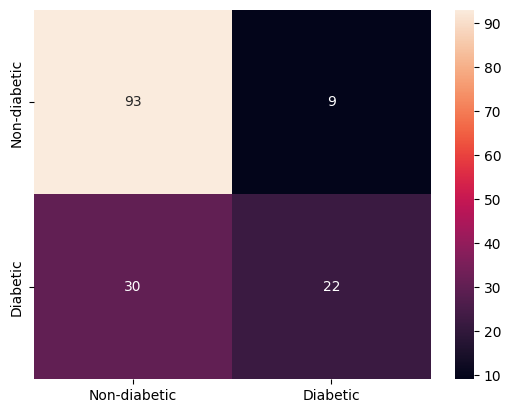

In [124]:
#model1high
evalFunction(model1high, loaderHigh, highEpochLog1, highTrainAccLog1, highTrainLossLog1, highValidationAccLog1, highValidationLossLog1, 'Model 1 high')

<Figure size 1000x800 with 0 Axes>

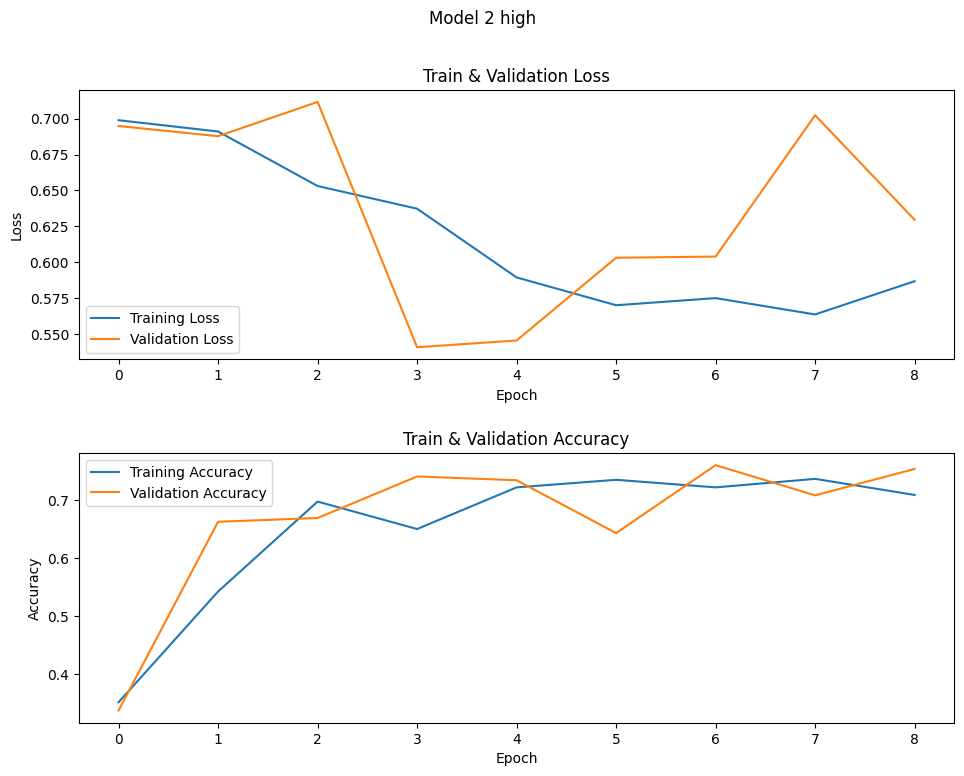

              precision    recall  f1-score   support

Non-diabetic       0.75      0.93      0.83       102
    Diabetic       0.75      0.40      0.53        52

    accuracy                           0.75       154
   macro avg       0.75      0.67      0.68       154
weighted avg       0.75      0.75      0.73       154

accuracy on the model was 75.32467532467533%


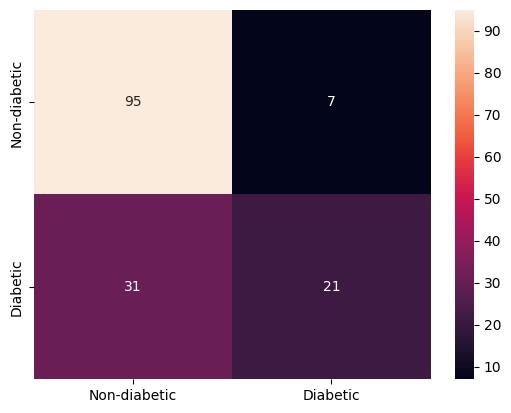

In [125]:
#model2high
evalFunction(model2high, loaderHigh, highEpochLog2, highTrainAccLog2, highTrainLossLog2, highValidationAccLog2, highValidationLossLog2, 'Model 2 high')

<Figure size 1000x800 with 0 Axes>

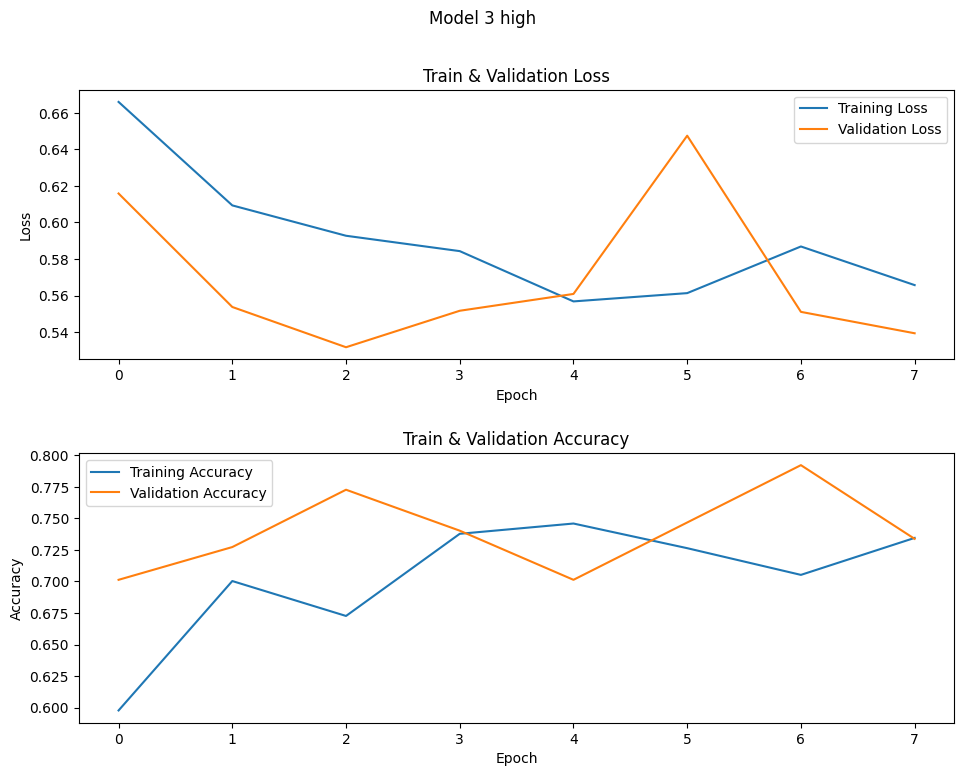

              precision    recall  f1-score   support

Non-diabetic       0.89      0.69      0.77       102
    Diabetic       0.57      0.83      0.68        52

    accuracy                           0.73       154
   macro avg       0.73      0.76      0.73       154
weighted avg       0.78      0.73      0.74       154

accuracy on the model was 73.37662337662337%


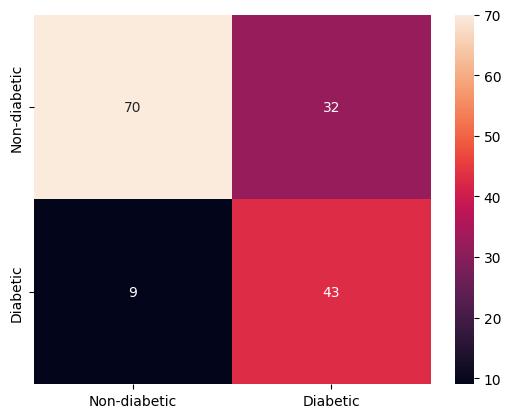

In [126]:
#model3high
evalFunction(model3high, loaderHigh, highEpochLog3, highTrainAccLog3, highTrainLossLog3, highValidationAccLog3, highValidationLossLog3, 'Model 3 high')

<Figure size 1000x800 with 0 Axes>

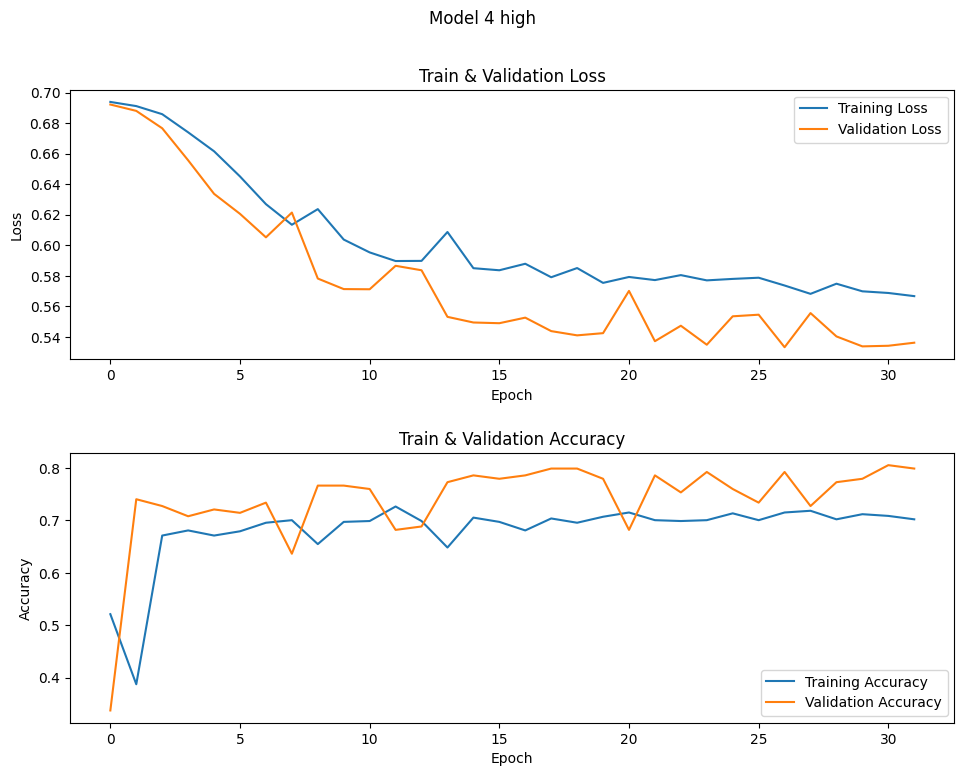

              precision    recall  f1-score   support

Non-diabetic       0.93      0.75      0.83       102
    Diabetic       0.65      0.88      0.75        52

    accuracy                           0.80       154
   macro avg       0.79      0.82      0.79       154
weighted avg       0.83      0.80      0.80       154

accuracy on the model was 79.87012987012987%


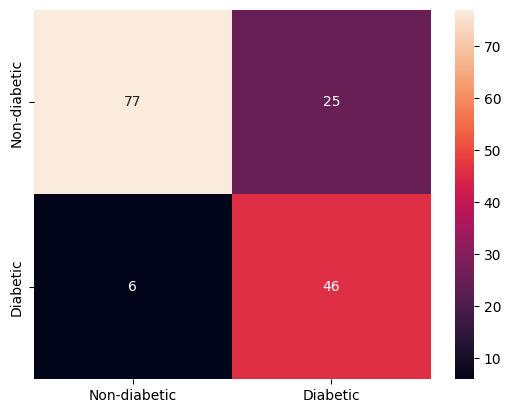

In [127]:
#model4high
evalFunction(model4high, loaderHigh, highEpochLog4, highTrainAccLog4, highTrainLossLog4, highValidationAccLog4, highValidationLossLog4, 'Model 4 high')

## Best Model